### Envsetup

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip install gpytorch

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import torch
import gpytorch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Visualization

In [3]:
def visimg(img1, img2, figsize=(10, 4)):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    axs[0].imshow(img1, cmap="grey")
    axs[1].imshow(img2, cmap="grey")
    axs[0].axis("off")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

In [4]:
def visflo(u, v, c, sr, scale, agg=max, log=True, figsize=(10, 5), title=""):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes([0.05, 0.5, 0.4, 0.4])
    ax2 = fig.add_axes([0.55, 0.5, 0.4, 0.4])
    ax3 = fig.add_axes([0.00, 0.0, 0.3, 0.4])
    ax4 = fig.add_axes([0.35, 0.0, 0.3, 0.4])
    ax5 = fig.add_axes([0.70, 0.0, 0.3, 0.4])

    mag = np.sqrt(u ** 2 + v ** 2)
    im1 = ax3.imshow(mag, cmap="viridis")
    im2 = ax4.imshow(u,   cmap="coolwarm")
    im3 = ax5.imshow(v,   cmap="coolwarm")

    plt.colorbar(im1, ax=ax3, shrink=0.8)
    plt.colorbar(im2, ax=ax4, shrink=0.8)
    plt.colorbar(im3, ax=ax5, shrink=0.8)

    yy, xx = np.mgrid[0:u.shape[0]:sr[0], 0:u.shape[1]:sr[1]]
    uu, vv = u[::sr[0], ::sr[1]], v[::sr[0], ::sr[1]]
    ax1.quiver(xx, yy, uu, -vv, scale=scale)
    ax1.invert_yaxis()

    ax1.set(title="Vector Field", xticks=[], yticks=[])
    ax2.set(title="Covariance",   xticks=[], yticks=[])
    ax3.set(title="Magnitude",    xticks=[], yticks=[])
    ax4.set(title="U Component",  xticks=[], yticks=[])
    ax5.set(title="V Component",  xticks=[], yticks=[])

    viscov(c, (1, 1), agg, log, ax2)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [5]:
def viscov(cov, sr, agg=max, log=True, axs=None):
    if show := (axs is None):
        fig, axs = plt.subplots(figsize=(5, 4))

    yy, xx = np.mgrid[0:cov.shape[0]:sr[0], 0:cov.shape[1]:sr[1]]
    eig = np.zeros_like(xx, dtype=np.float32)
    cc = cov[::sr[0], ::sr[1]]
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            eig[i, j] = agg(np.linalg.eigvals(cc[i, j]))

    eig = np.log(eig) if log else eig
    cm = axs.pcolormesh(xx, yy, eig, cmap="Greys_r")
    plt.colorbar(cm, ax=axs)
    axs.invert_yaxis()

    if show:
        axs.axis("off")
        plt.show()

### Maximum Likelihood

In [6]:
def gaussian_mask(window=5, sigma=None, normalize=True):
    if not sigma:
        sigma = window / 3
    center = (window - 1) / 2
    x = np.arange(window) - center
    y = np.arange(window) - center
    xx, yy = np.meshgrid(x, y)
    mask = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    return mask / mask.sum() if normalize else mask

In [7]:
def maximum_likelihood(img1, img2, window=9, sigma=1, rhos=[]):
    w = window // 2
    pad1 = cv.copyMakeBorder(img1.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    pad2 = cv.copyMakeBorder(img2.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    Ix = cv.Sobel(pad1, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(pad2, cv.CV_32F, 0, 1, ksize=3)
    It = pad2 - pad1

    u = np.zeros(img1.shape, dtype=np.float32)
    v = np.zeros(img1.shape, dtype=np.float32)
    c = np.zeros(img1.shape + (2, 2), dtype=np.float32)
    mask = gaussian_mask(window, normalize=False)
    noise = ((sigma / mask) ** 2).flatten()
    noise = np.diag(noise) if len(rhos) else noise

    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            m, n = i + w, j + w
            ix = Ix[m-w:m+w+1, n-w:n+w+1].flatten()
            iy = Iy[m-w:m+w+1, n-w:n+w+1].flatten()
            it = It[m-w:m+w+1, n-w:n+w+1].flatten()
            nabla = np.vstack([ix, iy])

            if len(rhos):
                cornoise = correlate(noise, rhos, (m, n), window)
                nabnoise = nabla @ np.linalg.inv(cornoise)
                ercov = np.linalg.inv(nabnoise @ nabla.T)
                flows = -ercov @ nabnoise @ it
            else:
                ercov = np.linalg.inv((nabla / noise) @ nabla.T)
                flows = -ercov @ (nabla / noise) @ it

            u[i, j] = flows[0]
            v[i, j] = flows[1]
            c[i, j] = ercov
    return u, v, c

### Multiresolution Algorithm

In [8]:
def gaussian_pyramid(img, levels):
    pyramid = [img.astype(np.float32)]
    for _ in range(levels - 1):
        pyramid.append(cv.pyrDown(pyramid[-1]))
    return pyramid[::-1]

In [9]:
def measurement_update(img1, img2, uu, vv, cc, window=9, sigma=1):
    w = window // 2
    pad1 = cv.copyMakeBorder(img1.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    pad2 = cv.copyMakeBorder(img2.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    Ix = cv.Sobel(pad1, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(pad1, cv.CV_32F, 0, 1, ksize=3)
    It = pad2 - pad1
    
    u  = np.zeros(img1.shape, dtype=np.float32)
    v  = np.zeros(img1.shape, dtype=np.float32)
    c  = np.zeros(img1.shape + (2, 2), dtype=np.float32)
    mask = gaussian_mask(window, normalize=False)
    noise = ((sigma / mask) ** 2).flatten()

    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            m, n = i + w, j + w
            ix = Ix[m-w:m+w+1, n-w:n+w+1].flatten()
            iy = Iy[m-w:m+w+1, n-w:n+w+1].flatten()
            it = It[m-w:m+w+1, n-w:n+w+1].flatten()
            
            nabla = np.vstack([ix, iy])
            fpred = np.array([uu[i, j], vv[i, j]])
            innovation = it + nabla.T @ fpred
            
            ercov = np.linalg.inv(cc[i, j])
            ercov = np.linalg.inv((nabla / noise) @ nabla.T + ercov)
            fpost = fpred - ercov @ (nabla / noise) @ innovation
            
            u[i, j] = fpost[0]
            v[i, j] = fpost[1]
            c[i, j] = ercov
    return u, v, c

In [10]:
def multiresolution_flows(img1, img2, window, sigmaQ, sigmaR, k=3, r=2):
    lvls = int(np.log2(img1.shape).min() - k)
    pyr1 = gaussian_pyramid(img1, lvls)
    pyr2 = gaussian_pyramid(img2, lvls)
    u1, v1, c1 = maximum_likelihood(pyr1[0], pyr2[0], window[0], sigmaR[0])
    pyramid = [(u1, v1, c1)]
    A = r * np.eye(2)

    for i in range(1, len(pyr1)):
        h, w = pyr1[i].shape
        u2 = cv.pyrUp(u1, dstsize=(w, h)) * r
        v2 = cv.pyrUp(v1, dstsize=(w, h)) * r
        
        c2 = np.zeros((h, w) + (2, 2))
        for m in range(2):
            for n in range(2):
                c2[..., m, n] = cv.pyrUp(c1[..., m, n], dstsize=(w, h)) * (r ** 2)
        c2 += (sigmaQ[i] * np.eye(2))[None, None, ...]

        
        u1, v1, c1 = measurement_update(
            pyr1[i], pyr2[i], u2, v2, c2, window[i], sigmaR[i]
        )
        pyramid.append((u1, v1, c1))
    return pyramid

### Homoscedastic GPR

In [11]:
class GPROFE(gpytorch.models.ExactGP):
    def __init__(self, X, Y, likelihood):
        super(GPROFE, self).__init__(X, Y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )
    def forward(self, X):
        mean = self.mean_module(X)
        covar = self.covar_module(X)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)

In [12]:
def train(model, likelihood, X, Y, lr=0.1, epochs=100):
    model.train()
    likelihood.train()
    opti = torch.optim.Adam(model.parameters(), lr=lr)
    emll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for n in range(epochs):
        opti.zero_grad()
        output = model(X)
        loss = -emll(output, Y)
        loss.backward()
        opti.step()
        if not (n + 1) % 10:
            print(f"Iteration {n + 1}: Loss {loss.item()}")

In [13]:
def pred(model, likelihood, X):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model(X)
    return pred.mean, pred.variance, pred.covariance_matrix

### Empirical Images

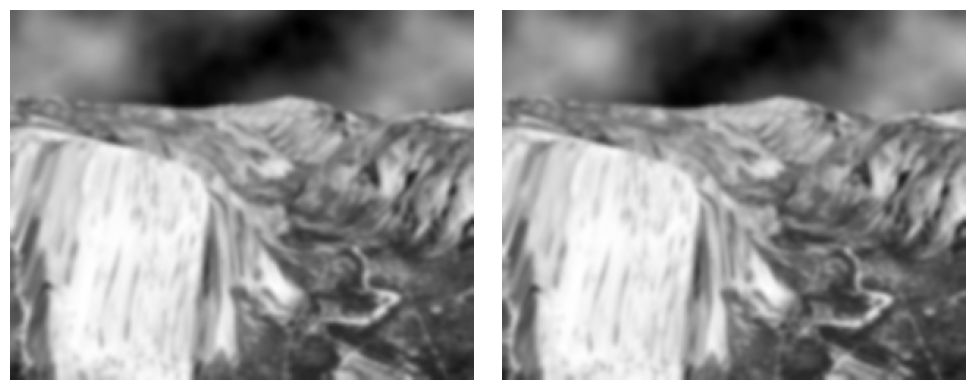

In [14]:
img1 = cv.imread("yosemite/YOS02.bmp")
img2 = cv.imread("yosemite/YOS03.bmp")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
img1 = cv.GaussianBlur(img1, (9, 9), -1)
img2 = cv.GaussianBlur(img2, (9, 9), -1)
visimg(img1, img2)

### Training (Maximum Likelihood)

In [15]:
u, v, c = maximum_likelihood(img1, img2, 9, 1)
yy, xx = np.mgrid[0:img1.shape[0]:9, 0:img1.shape[1]:9]
uu, vv = u[::9, ::9], v[::9, ::9]
X = torch.tensor(np.dstack((xx, yy)).reshape(-1, 2), dtype=torch.float32)
Y = torch.tensor(np.dstack((uu, vv)).reshape(-1, 2), dtype=torch.float32)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, rank=1)
model = GPROFE((X - X.mean()) / X.std(), Y, likelihood)

In [16]:
train(model, likelihood, (X - X.mean()) / X.std(), Y, epochs=200)

Iteration 10: Loss 0.5972827076911926
Iteration 20: Loss 0.17682993412017822
Iteration 30: Loss -0.06706013530492783
Iteration 40: Loss -0.08682172000408173
Iteration 50: Loss -0.1047048419713974
Iteration 60: Loss -0.1165187805891037
Iteration 70: Loss -0.1268419474363327
Iteration 80: Loss -0.134079709649086
Iteration 90: Loss -0.1410340815782547
Iteration 100: Loss -0.1496264785528183
Iteration 110: Loss -0.152040034532547
Iteration 120: Loss -0.1524437814950943
Iteration 130: Loss -0.15264202654361725
Iteration 140: Loss -0.1527169793844223
Iteration 150: Loss -0.1527479887008667
Iteration 160: Loss -0.15275537967681885
Iteration 170: Loss -0.1527591347694397
Iteration 180: Loss -0.1527605801820755
Iteration 190: Loss -0.15276142954826355
Iteration 200: Loss -0.152761310338974


/home/andy/tensorflow/lib64/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/tmp/ipykernel_185504/1755793235.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


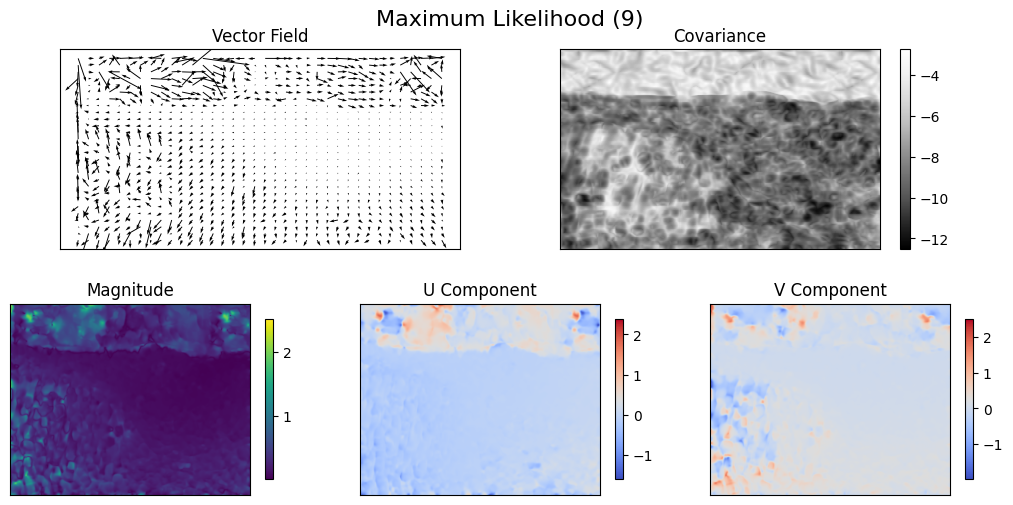

/tmp/ipykernel_185504/1755793235.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mag = np.sqrt(u ** 2 + v ** 2)


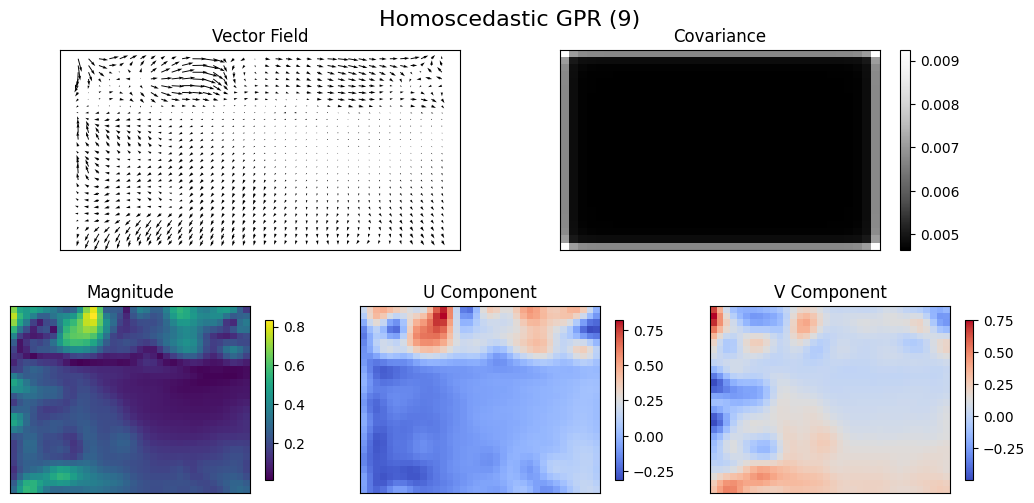

In [17]:
mean, var, covar = pred(model, likelihood, (X - X.mean()) / X.std())
uu = mean.reshape(xx.shape + (2,))[..., 0]
vv = mean.reshape(xx.shape + (2,))[..., 1]
cc = [covar.detach()[i:i+2, i:i+2] for i in range(0, covar.shape[0], 2)]
cc = np.array(cc).reshape(xx.shape + (2, 2))
visflo(u, v, c, (9, 9), 20, title="Maximum Likelihood (9)")
visflo(uu, vv, cc, (1, 1), 20, title="Homoscedastic GPR (9)", log=False)

### Diagnostics (Maximum Likelihood)

In [18]:
np.unique(cc), cc[0, 0]

(array([2.1245331e-05, 2.1247426e-05, 2.1248823e-05, ..., 9.2517491e-03,
        9.2518702e-03, 9.2519056e-03], dtype=float32),
 array([[8.3266646e-03, 2.1248823e-05],
        [2.1248823e-05, 9.2518702e-03]], dtype=float32))

In [19]:
(likelihood(model((X - X.mean()) / X.std())).covariance_matrix - covar)[:2, :2]

tensor([[0.0274, 0.0027],
        [0.0027, 0.0388]], grad_fn=<SliceBackward0>)

In [20]:
list(model.named_parameters())

[('likelihood.task_noise_covar_factor',
  Parameter containing:
  tensor([[0.0244],
          [0.1097]], requires_grad=True)),
 ('likelihood.raw_noise',
  Parameter containing:
  tensor([-3.6107], requires_grad=True)),
 ('mean_module.base_means.0.raw_constant',
  Parameter containing:
  tensor(0.0176, requires_grad=True)),
 ('mean_module.base_means.1.raw_constant',
  Parameter containing:
  tensor(0.0872, requires_grad=True)),
 ('covar_module.task_covar_module.covar_factor',
  Parameter containing:
  tensor([[ 0.0844],
          [-0.0367]], requires_grad=True)),
 ('covar_module.task_covar_module.raw_var',
  Parameter containing:
  tensor([-3.5766, -3.6003], requires_grad=True)),
 ('covar_module.data_covar_module.raw_lengthscale',
  Parameter containing:
  tensor([[-1.4671]], requires_grad=True))]

### Training (Multiresolution)

In [21]:
u, v, c = multiresolution_flows(
    img1, img2,
    [  9,  9,  9,  9,   9],
    [256, 64, 16,  4,   1],
    [  1,  4, 16, 64, 256]
)[-1]
yy, xx = np.mgrid[0:img1.shape[0]:9, 0:img1.shape[1]:9]
uu, vv = u[::9, ::9], v[::9, ::9]
X = torch.tensor(np.dstack((xx, yy)).reshape(-1, 2), dtype=torch.float32)
Y = torch.tensor(np.dstack((uu, vv)).reshape(-1, 2), dtype=torch.float32)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, rank=1)
model = GPROFE((X - X.mean()) / X.std(), Y, likelihood)

In [22]:
train(model, likelihood, (X - X.mean()) / X.std(), Y, epochs=200)

Iteration 10: Loss 0.4663335382938385
Iteration 20: Loss 0.07367034256458282
Iteration 30: Loss -0.1921103298664093
Iteration 40: Loss -0.2423570454120636
Iteration 50: Loss -0.2579154372215271
Iteration 60: Loss -0.3064509928226471
Iteration 70: Loss -0.32960522174835205
Iteration 80: Loss -0.3836197555065155
Iteration 90: Loss -0.40795594453811646
Iteration 100: Loss -0.41507792472839355
Iteration 110: Loss -0.41635242104530334
Iteration 120: Loss -0.4164966344833374
Iteration 130: Loss -0.4167972207069397
Iteration 140: Loss -0.4168805181980133
Iteration 150: Loss -0.4169338047504425
Iteration 160: Loss -0.41693636775016785
Iteration 170: Loss -0.4169173538684845
Iteration 180: Loss -0.4166572093963623
Iteration 190: Loss -0.4167352020740509
Iteration 200: Loss -0.41684794425964355


/tmp/ipykernel_185504/1755793235.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


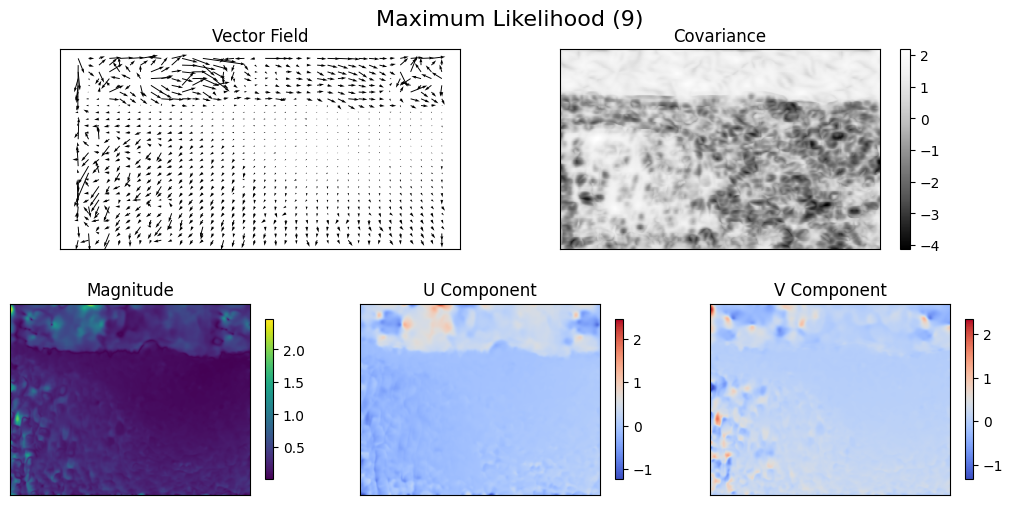

/tmp/ipykernel_185504/1755793235.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mag = np.sqrt(u ** 2 + v ** 2)


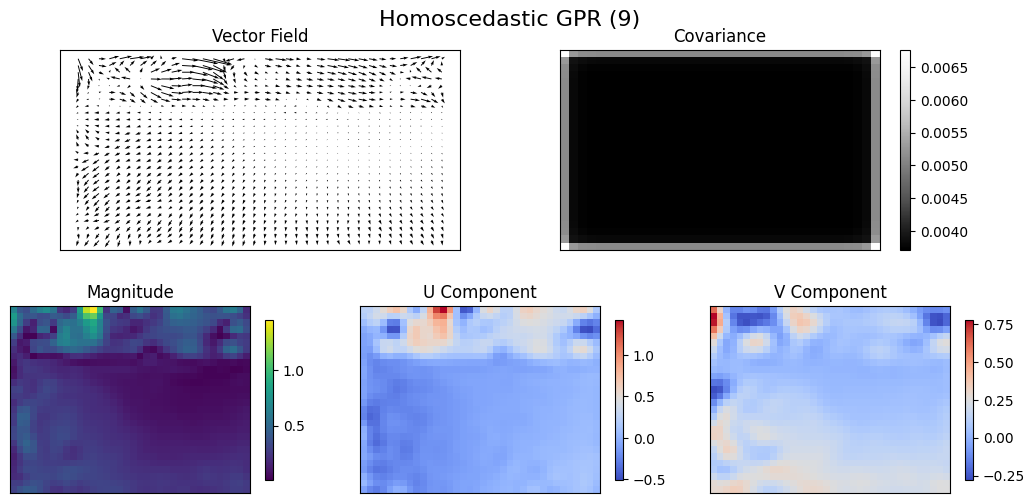

In [23]:
mean, var, covar = pred(model, likelihood, (X - X.mean()) / X.std())
uu = mean.reshape(xx.shape + (2,))[..., 0]
vv = mean.reshape(xx.shape + (2,))[..., 1]
cc = [covar.detach()[i:i+2, i:i+2] for i in range(0, covar.shape[0], 2)]
cc = np.array(cc).reshape(xx.shape + (2, 2))
visflo(u, v, c, (9, 9), 20, title="Maximum Likelihood (9)")
visflo(uu, vv, cc, (1, 1), 20, title="Homoscedastic GPR (9)", log=False)

/home/andy/tensorflow/lib64/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/tmp/ipykernel_185504/1755793235.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


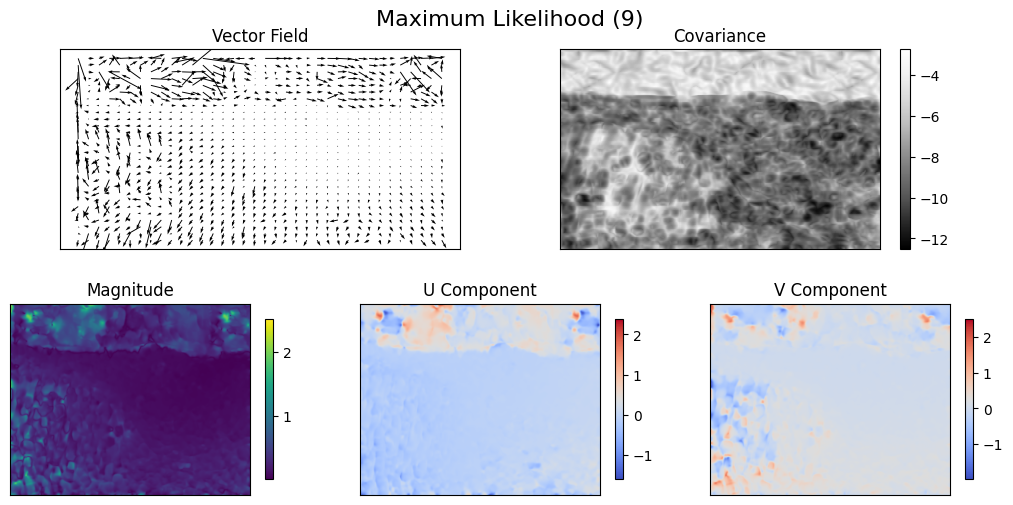

/tmp/ipykernel_185504/1755793235.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mag = np.sqrt(u ** 2 + v ** 2)


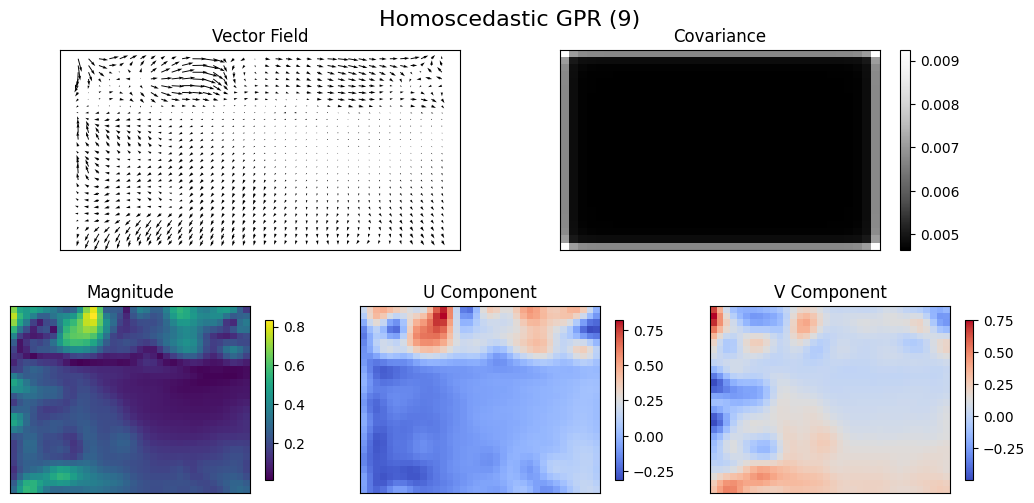

In [17]:
mean, var, covar = pred(model, likelihood, (X - X.mean()) / X.std())
uu = mean.reshape(xx.shape + (2,))[..., 0]
vv = mean.reshape(xx.shape + (2,))[..., 1]
cc = [covar.detach()[i:i+2, i:i+2] for i in range(0, covar.shape[0], 2)]
cc = np.array(cc).reshape(xx.shape + (2, 2))
visflo(u, v, c, (9, 9), 20, title="Maximum Likelihood (9)")
visflo(uu, vv, cc, (1, 1), 20, title="Homoscedastic GPR (9)", log=False)

### Diagnostics (Multiresolution)

In [24]:
np.unique(cc), cc[0, 0]

(array([-0.0006567 , -0.00065669, -0.00065669, ...,  0.0065023 ,
         0.0065023 ,  0.00650234], dtype=float32),
 array([[ 0.00514087, -0.0006567 ],
        [-0.0006567 ,  0.0065023 ]], dtype=float32))

In [25]:
(likelihood(model((X - X.mean()) / X.std())).covariance_matrix - covar)[:2, :2]

tensor([[ 0.0098, -0.0039],
        [-0.0039,  0.0266]], grad_fn=<SliceBackward0>)

In [26]:
list(model.named_parameters())

[('likelihood.task_noise_covar_factor',
  Parameter containing:
  tensor([[ 0.0290],
          [-0.1327]], requires_grad=True)),
 ('likelihood.raw_noise',
  Parameter containing:
  tensor([-4.7167], requires_grad=True)),
 ('mean_module.base_means.0.raw_constant',
  Parameter containing:
  tensor(0.0329, requires_grad=True)),
 ('mean_module.base_means.1.raw_constant',
  Parameter containing:
  tensor(0.1169, requires_grad=True)),
 ('covar_module.task_covar_module.covar_factor',
  Parameter containing:
  tensor([[-0.1905],
          [-0.0132]], requires_grad=True)),
 ('covar_module.task_covar_module.raw_var',
  Parameter containing:
  tensor([-3.9347, -4.0302], requires_grad=True)),
 ('covar_module.data_covar_module.raw_lengthscale',
  Parameter containing:
  tensor([[-1.5950]], requires_grad=True))]